In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install torch torchvision pillow opencv-python numpy


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained model
model = models.resnet34(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)  # assuming 7 emotion classes

# Load your saved weights
model.load_state_dict(torch.load('/content/drive/MyDrive/models/resnet34.pth', map_location='cpu'))
model.eval()

print("✅ ResNet34 model loaded successfully!")


✅ ResNet34 model loaded successfully!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully on: cuda
📤 Upload a face image to test emotion detection


Saving photo-1624272949900-9ae4c56397e8.jpeg to photo-1624272949900-9ae4c56397e8 (1).jpeg
🧠 Predicted Emotion: Happy


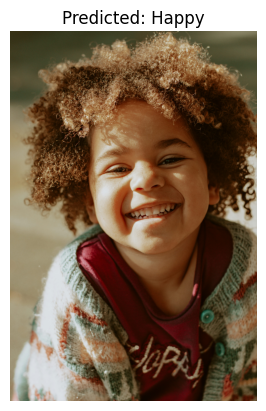

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
from google.colab import files


model = models.resnet34(pretrained=False)
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)


from google.colab import drive
drive.mount('/content/drive')


model.load_state_dict(torch.load(
    '/content/drive/MyDrive/models/resnet34.pth',
    map_location='cuda' if torch.cuda.is_available() else 'cpu'
))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("✅ Model loaded successfully on:", device)


class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def predict_emotion(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)

    emotion = class_names[predicted.item()]
    print(f"🧠 Predicted Emotion: {emotion}")

    # Show image with prediction
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f"Predicted: {emotion}")
    plt.axis('off')
    plt.show()

print("📤 Upload a face image to test emotion detection")
uploaded = files.upload()

for filename in uploaded.keys():
    predict_emotion(filename)


In [5]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [6]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/sad/Training_65242339.jpg  
  inflating: ./data/train/sad/Training_65267116.jpg  
  inflating: ./data/train/sad/Training_65275626.jpg  
  inflating: ./data/train/sad/Training_6529266.jpg  
  inflating: ./data/train/sad/Training_65329617.jpg  
  inflating: ./data/train/sad/Training_65338712.jpg  
  inflating: ./data/train/sad/Training_65338797.jpg  
  inflating: ./data/train/sad/Training_65387162.jpg  
  inflating: ./data/train/sad/Training_65404494.jpg  
  inflating: ./data/train/sad/Training_65426218.jpg  
  inflating: ./data/train/sad/Training_65430136.jpg  
  inflating: ./data/train/sad/Training_65437377.jpg  
  inflating: ./data/train/sad/Training_6545735.jpg  
  inflating: ./data/train/sad/Training_65463385.jpg  
  inflating: ./data/train/sad/Training_65473985.jpg  
  inflating: ./data/train/sad/Training_65502829.jpg  
  inflating: ./data/train/sad/Training_65505359.jpg  
  inflating: ./data/train/sad/Tra

In [17]:
# ============================
# EMOTION RECOGNITION ENSEMBLE
# ============================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
from tqdm import tqdm
import os

# ----------------------------
# 1. Google Drive Mount
# ----------------------------
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# 2. Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

models_path = "/content/drive/MyDrive/models"
test_dir = "./data/test"

# ----------------------------
# 3. Transforms
# ----------------------------
transform_common = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_inception = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# 4. Attention Modules (same as before)
# ----------------------------
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=(2,3), keepdim=True)
        max_out, _ = torch.max(x, dim=2, keepdim=True)
        max_out, _ = torch.max(max_out, dim=3, keepdim=True)
        avg_out = self.fc2(self.relu1(self.fc1(avg_out)))
        max_out = self.fc2(self.relu1(self.fc1(max_out)))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BAM(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        x_out = self.ca(x) * x
        x_out = self.sa(x_out) * x_out
        return x_out

class BAM_ResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.resnet = models.resnet50(weights=None)
        self.bam1, self.bam2, self.bam3, self.bam4 = BAM(256), BAM(512), BAM(1024), BAM(2048)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x); x = self.bam1(x)
        x = self.resnet.layer2(x); x = self.bam2(x)
        x = self.resnet.layer3(x); x = self.bam3(x)
        x = self.resnet.layer4(x); x = self.bam4(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)

class CBAMBlock(nn.Module):
    def __init__(self, channels, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class CBAM_ResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.resnet = models.resnet50(weights=None)
        self.cbam1, self.cbam2, self.cbam3, self.cbam4 = CBAMBlock(256), CBAMBlock(512), CBAMBlock(1024), CBAMBlock(2048)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x); x = self.cbam1(x)
        x = self.resnet.layer2(x); x = self.cbam2(x)
        x = self.resnet.layer3(x); x = self.cbam3(x)
        x = self.resnet.layer4(x); x = self.cbam4(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)

# ----------------------------
# 5. Model Loaders (same as before)
# ----------------------------
def load_resnet34(path, num_classes):
    model = models.resnet34(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_resnet152(path, num_classes):
    model = models.resnet152(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_densenet121(path, num_classes):
    model = models.densenet121(weights=None)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_efficientnet_b2(path, num_classes):
    model = timm.create_model("efficientnet_b2", pretrained=False, num_classes=num_classes)
    state = torch.load(path, map_location=device)
    new_state = {k.replace("module.", "").replace("model.", ""): v for k, v in state.items()}
    model.load_state_dict(new_state, strict=False)
    return model.to(device).eval()

def load_googlenet(path, num_classes):
    model = models.googlenet(weights=None, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    state_dict = torch.load(path, map_location=device)
    filtered_state = {k: v for k, v in state_dict.items() if not (k.startswith('aux1.') or k.startswith('aux2.'))}
    model.load_state_dict(filtered_state, strict=False)
    return model.to(device).eval()

def load_inception_v3(path, num_classes):
    model = models.inception_v3(weights=None, aux_logits=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    state_dict = torch.load(path, map_location=device)
    filtered_state = {k: v for k, v in state_dict.items() if not k.startswith('AuxLogits.')}
    model.load_state_dict(filtered_state, strict=False)
    model.aux_logits = False
    return model.to(device).eval()

def load_vgg19(path, num_classes):
    model = models.vgg19(weights=None)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    return model.to(device).eval()

def load_bam_resnet50(path, num_classes):
    model = BAM_ResNet50(num_classes)
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    return model.to(device).eval()

def load_cbam_resnet50(path, num_classes):
    model = CBAM_ResNet50(num_classes)
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    return model.to(device).eval()

# ----------------------------
# 6. Dataset
# ----------------------------
test_dataset_224 = datasets.ImageFolder(test_dir, transform=transform_common)
test_dataset_299 = datasets.ImageFolder(test_dir, transform=transform_inception)
test_loader_224 = DataLoader(test_dataset_224, batch_size=32, shuffle=False)
test_loader_299 = DataLoader(test_dataset_299, batch_size=32, shuffle=False)
num_classes = len(test_dataset_224.classes)
print(f"Number of classes: {num_classes}")

# ----------------------------
# 7. Load Models
# ----------------------------
models_list = [
    ("ResNet34", load_resnet34(f"{models_path}/resnet34.pth", num_classes), test_loader_224),
    ("ResNet152", load_resnet152(f"{models_path}/resnet152.pth", num_classes), test_loader_224),
    ("DenseNet121", load_densenet121(f"{models_path}/densenet121.pth", num_classes), test_loader_224),
    ("EfficientNet-B2", load_efficientnet_b2(f"{models_path}/efficientnet_b2.pth", num_classes), test_loader_224),
    ("GoogLeNet", load_googlenet(f"{models_path}/googlenet.pth", num_classes), test_loader_224),
    ("InceptionV3", load_inception_v3(f"{models_path}/inception_v3.pth", num_classes), test_loader_299),
    ("VGG19", load_vgg19(f"{models_path}/vgg19.pth", num_classes), test_loader_224),
    ("BAM-ResNet50", load_bam_resnet50(f"{models_path}/bam_resnet50.pth", num_classes), test_loader_224),
    ("CBAM-ResNet50", load_cbam_resnet50(f"{models_path}/cbam_resnet50.pth", num_classes), test_loader_224),
]

# =======================================
# 8. Evaluation (Improved Weighted + TTA Ensemble)
# =======================================
import numpy as np

# --- Test-time augmentation helper ---
def tta_predict(model, imgs, tta_transforms):
    """Apply TTA and average model predictions"""
    model.eval()
    all_probs = []
    with torch.no_grad():
        for tform in tta_transforms:
            aug_imgs = torch.stack([tform(img.cpu()) for img in imgs])
            aug_imgs = aug_imgs.to(device)
            outputs = F.softmax(model(aug_imgs), dim=1)
            all_probs.append(outputs)
    return torch.stack(all_probs).mean(dim=0)


# --- Simple augmentations for TTA ---
tta_transforms = [
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)]),
    transforms.Compose([transforms.RandomRotation(10)]),
    transforms.Compose([]),  # original
]


def evaluate_single_model(model, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


def evaluate_ensemble_weighted_tta(models_list, model_weights, temperature=1.5):
    """Weighted soft-voting ensemble with TTA"""
    print("\nRunning weighted + TTA ensemble...")

    # Collect probabilities for all models
    all_probs = []
    for i, (name, model, loader) in enumerate(models_list):
        print(f"→ {name} ...")
        probs = []
        with torch.no_grad():
            for imgs, _ in loader:
                imgs = imgs.to(device)
                # Apply TTA
                outputs = tta_predict(model, imgs, tta_transforms)
                # Temperature scaling
                outputs = F.softmax(outputs / temperature, dim=1)
                probs.append(outputs.cpu())
        all_probs.append(torch.cat(probs))

    # Weighted average
    stacked = torch.stack(all_probs)  # (num_models, N, num_classes)
    weights = torch.tensor(model_weights).view(-1, 1, 1)
    mean_probs = torch.sum(stacked * weights, dim=0) / sum(model_weights)

    # Final predictions
    true_labels = torch.cat([labels for _, labels in test_loader_224])
    preds = mean_probs.argmax(dim=1)
    acc = (preds == true_labels).float().mean().item()
    return acc


# --- Compute base accuracies first ---
print("\n=============================")
print("Individual Model Accuracies")
print("=============================")
accuracies = []
for name, model, loader in models_list:
    acc = evaluate_single_model(model, loader)
    accuracies.append(acc)
    print(f"{name:20s}: {acc*100:.2f}%")

# --- Assign ensemble weights (normalized) ---
# Give higher weight to stronger models
weights = np.array(accuracies)
weights = weights / weights.sum()

print("\n=============================")
print("Weighted + TTA Ensemble")
print("=============================")
ensemble_acc = evaluate_ensemble_weighted_tta(models_list, weights.tolist())
print(f"Improved Weighted Ensemble Accuracy: {ensemble_acc*100:.2f}%")
print("=============================")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Number of classes: 7

Individual Model Accuracies
ResNet34            : 66.47%
ResNet152           : 65.13%
DenseNet121         : 68.22%
EfficientNet-B2     : 69.92%
GoogLeNet           : 54.40%
InceptionV3         : 34.70%
VGG19               : 66.62%
BAM-ResNet50        : 65.87%
CBAM-ResNet50       : 63.44%

Weighted + TTA Ensemble

Running weighted + TTA ensemble...
→ ResNet34 ...
→ ResNet152 ...
→ DenseNet121 ...
→ EfficientNet-B2 ...
→ GoogLeNet ...
→ InceptionV3 ...
→ VGG19 ...
→ BAM-ResNet50 ...
→ CBAM-ResNet50 ...
Improved Weighted Ensemble Accuracy: 72.61%


In [ ]:
ensemble_dict = {name: model.state_dict() for name, model, _ in models_list}
torch.save(ensemble_dict, "/content/drive/MyDrive/models/ensemble_all_models.pth")

In [ ]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.4 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2ub0L3c1GuWyLNpD67KRBTnI3UO_5rv7gJt3u4TFRj466VKxQ")


In [ ]:
%%writefile app.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import timm
import streamlit as st
import os


st.set_page_config(page_title="Emotion Ensemble Recognition", layout="centered")
st.title("😊 Emotion Recognition using Ensemble Models")
st.write("Upload an image or capture via webcam. The app uses an ensemble of 9 models for emotion detection.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


models_path = "/content/drive/MyDrive/models"
num_classes = 7
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=(2,3), keepdim=True)
        max_out, _ = torch.max(x, dim=2, keepdim=True)
        max_out, _ = torch.max(max_out, dim=3, keepdim=True)
        avg_out = self.fc2(self.relu1(self.fc1(avg_out)))
        max_out = self.fc2(self.relu1(self.fc1(max_out)))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BAM(nn.Module):
    def __init__(self, in_planes):
        super().__init__()
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        x_out = self.ca(x) * x
        x_out = self.sa(x_out) * x_out
        return x_out

class CBAMBlock(nn.Module):
    def __init__(self, channels, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class BAM_ResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.resnet = models.resnet50(weights=None)
        self.bam1, self.bam2, self.bam3, self.bam4 = BAM(256), BAM(512), BAM(1024), BAM(2048)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x); x = self.bam1(x)
        x = self.resnet.layer2(x); x = self.bam2(x)
        x = self.resnet.layer3(x); x = self.bam3(x)
        x = self.resnet.layer4(x); x = self.bam4(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)

class CBAM_ResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.resnet = models.resnet50(weights=None)
        self.cbam1, self.cbam2, self.cbam3, self.cbam4 = CBAMBlock(256), CBAMBlock(512), CBAMBlock(1024), CBAMBlock(2048)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x); x = self.cbam1(x)
        x = self.resnet.layer2(x); x = self.cbam2(x)
        x = self.resnet.layer3(x); x = self.cbam3(x)
        x = self.resnet.layer4(x); x = self.cbam4(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)


@st.cache_resource
def load_all_models():
    def safe_load(model, path, num_classes=7):
        # Adjust classifier layer if needed before loading
        if isinstance(model, models.ResNet):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif isinstance(model, models.DenseNet):
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        elif isinstance(model, models.VGG):
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif isinstance(model, models.GoogLeNet):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif isinstance(model, models.Inception3):
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif "efficientnet" in model.__class__.__name__.lower():
            # for timm models like EfficientNet-B2
            in_features = model.get_classifier().in_features
            model.classifier = nn.Linear(in_features, num_classes)

        # Load checkpoint safely
        state = torch.load(path, map_location=device)
        model.load_state_dict(state, strict=False)
        model.to(device).eval()
        return model

    models_dict = {
        "ResNet34": safe_load(models.resnet34(weights=None), f"{models_path}/resnet34.pth"),
        "ResNet152": safe_load(models.resnet152(weights=None), f"{models_path}/resnet152.pth"),
        "DenseNet121": safe_load(models.densenet121(weights=None), f"{models_path}/densenet121.pth"),
        "EfficientNet-B2": safe_load(timm.create_model("efficientnet_b2", pretrained=False, num_classes=num_classes), f"{models_path}/efficientnet_b2.pth"),
        "GoogLeNet": safe_load(models.googlenet(weights=None), f"{models_path}/googlenet.pth"),
        "InceptionV3": safe_load(models.inception_v3(weights=None, aux_logits=False), f"{models_path}/inception_v3.pth"),
        "VGG19": safe_load(models.vgg19(weights=None), f"{models_path}/vgg19.pth"),
        "BAM-ResNet50": safe_load(BAM_ResNet50(num_classes), f"{models_path}/bam_resnet50.pth"),
        "CBAM-ResNet50": safe_load(CBAM_ResNet50(num_classes), f"{models_path}/cbam_resnet50.pth"),
    }

    return models_dict


models_dict = load_all_models()
st.success("All ensemble models loaded successfully.")

transform_224 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_299 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


import pandas as pd

def ensemble_predict(image):
    results = {}
    for name, model in models_dict.items():
        transform = transform_299 if "Inception" in name else transform_224
        img_t = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_t)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            pred_idx = probs.argmax()
            results[name] = {
                "emotion": class_names[pred_idx],
                "confidence": probs[pred_idx] * 100,
                "all_probs": probs
            }

    # Ensemble voting
    votes = [res["emotion"] for res in results.values()]
    final_emotion = max(set(votes), key=votes.count)

    return final_emotion, results


option = st.radio("Choose Input Mode:", ("Upload Image", "Use Webcam"))

if option == "Upload Image":
    uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_column_width=True)
        if st.button("Predict Emotion"):
          final_emotion, results = ensemble_predict(image)
          st.success(f"Final Detected Emotion: {final_emotion}")

          # Show confidence from each model
          st.subheader("Model-wise Predictions")
          table_data = []
          for name, res in results.items():
              table_data.append({
                  "Model": name,
                  "Predicted Emotion": res["emotion"],
                  "Confidence (%)": f"{res['confidence']:.2f}"
              })
          df = pd.DataFrame(table_data)
          st.dataframe(df)


          st.subheader("Confidence Distribution (Average across models)")
          avg_probs = sum([torch.tensor(r["all_probs"]) for r in results.values()]) / len(results)
          avg_probs = avg_probs.numpy()
          avg_df = pd.DataFrame({
              "Emotion": class_names,
              "Average Confidence (%)": avg_probs * 100
          })
          st.bar_chart(avg_df.set_index("Emotion"))


elif option == "Use Webcam":
    camera_image = st.camera_input("Take a picture")
    if camera_image is not None:
        image = Image.open(camera_image).convert("RGB")
        st.image(image, caption="Captured Image", use_column_width=True)
        if st.button("Predict Emotion"):
            final_emotion, results = ensemble_predict(image)
            st.success(f"Final Detected Emotion: {final_emotion}")

            # Show confidence from each model
            st.subheader("Model-wise Predictions")
            table_data = []
            for name, res in results.items():
                table_data.append({
                    "Model": name,
                    "Predicted Emotion": res["emotion"],
                    "Confidence (%)": f"{res['confidence']:.2f}"
                })
            df = pd.DataFrame(table_data)
            st.dataframe(df)


            st.subheader("Confidence Distribution (Average across models)")
            avg_probs = sum([torch.tensor(r["all_probs"]) for r in results.values()]) / len(results)
            avg_probs = avg_probs.numpy()
            avg_df = pd.DataFrame({
                "Emotion": class_names,
                "Average Confidence (%)": avg_probs * 100
            })
            st.bar_chart(avg_df.set_index("Emotion"))


st.markdown("---")
st.caption("HIT 401 - Ensemble Emotion Recognition (Colab + Streamlit + ngrok)")



Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Disconnect previous tunnels
ngrok.kill()

# Set your auth token again
ngrok.set_auth_token("2ub0L3c1GuWyLNpD67KRBTnI3UO_5rv7gJt3u4TFRj466VKxQ")

# Open a new tunnel
public_url = ngrok.connect(8501)
print("New Streamlit App URL:", public_url)


New Streamlit App URL: NgrokTunnel: "https://ee08e0ebcf8e.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run app.py --server.port 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.160.206:8501

/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
2025-10-08 16:50:13.841 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the